In [1]:
import numpy as np
import netCDF4 as nc
import scipy.signal as signal
import matplotlib.pyplot as plt
import pywt
from typing import Tuple, Optional

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [14]:
# Checking for GPU availability
import torch
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

False


In [3]:
# Loading the NetCDF file
data_path = "29AP2022SHT1_r5_BAPBS_p.nc"
dataset = nc.Dataset(data_path, 'r')

In [4]:
# Exploring variables
print("Variables in the dataset:", dataset.variables.keys())

Variables in the dataset: dict_keys(['Headers', 'Procparams', 'SpecProcparams', 'RawI.R.1.C.1.B.1', 'RawQ.R.1.C.1.B.1', 'SpecPSD.R.1.C.1.B.1', 'TracePeak.R.1.C.1.B.1', 'TraceUSPeak.R.1.C.1.B.1', 'TraceSP.R.1.C.1.B.1', 'MMTMT.R.1.C.1.B.1', 'MMTMain.R.1.C.1.B.1', 'MMTEM.R.1.C.1.B.1', 'RawI.R.1.C.1.B.2', 'RawQ.R.1.C.1.B.2', 'SpecPSD.R.1.C.1.B.2', 'TracePeak.R.1.C.1.B.2', 'TraceUSPeak.R.1.C.1.B.2', 'TraceSP.R.1.C.1.B.2', 'MMTMT.R.1.C.1.B.2', 'MMTMain.R.1.C.1.B.2', 'MMTEM.R.1.C.1.B.2', 'RawI.R.1.C.1.B.3', 'RawQ.R.1.C.1.B.3', 'SpecPSD.R.1.C.1.B.3', 'TracePeak.R.1.C.1.B.3', 'TraceUSPeak.R.1.C.1.B.3', 'TraceSP.R.1.C.1.B.3', 'MMTMT.R.1.C.1.B.3', 'MMTMain.R.1.C.1.B.3', 'MMTEM.R.1.C.1.B.3', 'RawI.R.1.C.1.B.4', 'RawQ.R.1.C.1.B.4', 'SpecPSD.R.1.C.1.B.4', 'TracePeak.R.1.C.1.B.4', 'TraceUSPeak.R.1.C.1.B.4', 'TraceSP.R.1.C.1.B.4', 'MMTMT.R.1.C.1.B.4', 'MMTMain.R.1.C.1.B.4', 'MMTEM.R.1.C.1.B.4', 'RawI.R.1.C.1.B.5', 'RawQ.R.1.C.1.B.5', 'SpecPSD.R.1.C.1.B.5', 'TracePeak.R.1.C.1.B.5', 'TraceUSPeak.R.1.C.1

In [5]:
# Constants
RANGE_BINS = 180
CYCLES = 17
BEAMS = 5
NFFT = 256
INCI = 5

In [6]:
iq_data = np.zeros((CYCLES, BEAMS, INCI, RANGE_BINS, NFFT), dtype=complex)

# Extract and combine RawI and RawQ for each cycle and beam
for c in range(1, CYCLES + 1):
    for b in range(1, BEAMS + 1):
        # Variable names follow the pattern 'RawI.R.1.C.{c}.B.{b}' and 'RawQ.R.1.C.{c}.B.{b}'
        raw_i_key = f'RawI.R.1.C.{c}.B.{b}'
        raw_q_key = f'RawQ.R.1.C.{c}.B.{b}'
        
        if raw_i_key in dataset.variables and raw_q_key in dataset.variables:
            raw_i = dataset.variables[raw_i_key][:]
            raw_q = dataset.variables[raw_q_key][:]
            
            iq_data[c-1, b-1, :, :, :] = raw_i + 1j * raw_q
        else:
            print(f"Warning: Variables {raw_i_key} or {raw_q_key} not found.")

print("IQ Data Shape:", iq_data.shape)

dataset.close()

IQ Data Shape: (17, 5, 5, 180, 256)


In [7]:
cycle_idx = 0
beam_idx = 0
iq_frames = iq_data[cycle_idx, beam_idx, :, :, :]

collated_data = np.zeros((RANGE_BINS, NFFT * INCI), dtype=complex)
for rb in range(RANGE_BINS):
    collated_data[rb, :] = np.concatenate([iq_frames[i, rb, :] for i in range(INCI)])

segments_per_bin = 12
segment_length = 512
segmented_data = np.zeros((RANGE_BINS, segments_per_bin, segment_length), dtype=complex)

for rb in range(RANGE_BINS):
    for seg in range(segments_per_bin):
        start = seg * (NFFT * INCI // segments_per_bin)
        end = start + segment_length
        segment = collated_data[rb, start:end]
        if len(segment) < segment_length:
            segment = np.pad(segment, (0, segment_length - len(segment)), mode='constant')
        segmented_data[rb, seg, :] = segment

# Apply Kaiser window to each segment
kaiser_window = signal.windows.kaiser(segment_length, beta=5.85)
segmented_data = segmented_data * kaiser_window[None, None, :]

print("Segmented Data Shape:", segmented_data.shape)

Segmented Data Shape: (180, 12, 512)


datawd_real min/max: -0.6449391114726534 2.511225211548076
datawd_imag min/max: -0.5275196591525189 3.6253650274105045
mu: 2.0 tau: 0.4 pseudos: 0.2169233760639239 sigma_d2: 0.08792364110997464
Level 4 - d_mag min/max: 0.000379482630932373 0.7514273072282864
Level 4 - delta_star min/max: 0.0005234255476121255 0.14898351759035436
Level 3 - d_mag min/max: 1.9415573010698148 3.694769422134482
Level 3 - delta_star min/max: 0.1999999866612177 0.19999999949819625


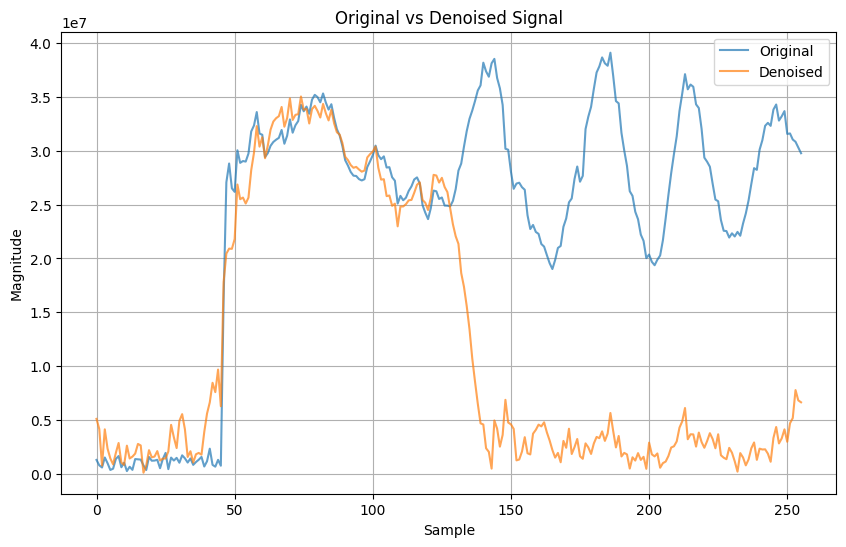

In [8]:
def mst_abs(
    signal: np.ndarray,
    wavelet: str = 'sym8',
    coarsest: int = 3,
    finestlev: int = 4,
    debug: bool = False
) -> np.ndarray:
    """
    Apply Adaptive-Bayesian Shrinkage to a complex signal using wavelet transforms.

    Args:
        signal: Complex input signal segment.
        wavelet: Wavelet type (default: 'sym8').
        coarsest: Coarsest decomposition level (default: 3).
        finestlev: Finest decomposition level (default: 4).
        debug: Enable debug printing (default: False).

    Returns:
        Denoised complex signal.
    """
    # Validate input
    if not np.iscomplexobj(signal):
        raise ValueError("Input signal must be complex.")

    # Separate real and imaginary parts
    real_part = signal.real
    imag_part = signal.imag

    # Forward Wavelet Transform
    coeffs_real = pywt.wavedec(real_part, wavelet, level=finestlev, mode='periodization')
    coeffs_imag = pywt.wavedec(imag_part, wavelet, level=finestlev, mode='periodization')
    datawd_real, coeff_slices = pywt.coeffs_to_array(coeffs_real)
    datawd_imag, _ = pywt.coeffs_to_array(coeffs_imag)

    if debug:
        print("datawd_real min/max:", datawd_real.min(), datawd_real.max())
        print("datawd_imag min/max:", datawd_imag.min(), datawd_imag.max())

    # Compute prior parameters
    datawd_mag = np.sqrt(datawd_real**2 + datawd_imag**2)
    niz = datawd_mag[2**finestlev:2**(finestlev+1)]
    nizo = np.sort(np.abs(niz))
    mm = len(nizo)
    Q1 = nizo[int(mm/4)] if mm > 0 else 0
    Q3 = nizo[int(3*mm/4)] if mm > 0 else 0
    pseudos = max(abs(Q1 - Q3) / 1.5, 1e-2)
    mu = min(1 / pseudos**2 if pseudos != 0 else 1e-1, 2.0)
    sigma_d2 = np.var(np.abs(signal))
    tau = max(np.sqrt(max(sigma_d2 - (1/mu), 1e-6)), 0.4)

    if debug:
        print("mu:", mu, "tau:", tau, "pseudos:", pseudos, "sigma_d2:", sigma_d2)

    # Iterative shrinkage
    for i in range(finestlev, coarsest-1, -1):
        epsilon = min(1 - (1 / (i - coarsest + 1)), 0.3)
        slice_start, slice_end = 2**i, (2**(i+1) if i < finestlev else len(datawd_real))
        d_real = datawd_real[slice_start:slice_end]
        d_imag = datawd_imag[slice_start:slice_end]
        if len(d_real) == 0:
            continue

        d_mag = np.maximum(np.sqrt(d_real**2 + d_imag**2), 1e-10)
        de = 0.5 * np.sqrt(2*mu) * np.exp(-np.sqrt(2*mu) * d_mag)
        m = (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.sqrt(2*mu)*d_mag)) / (2*tau**2 - (1/mu))
        m = np.maximum(m, 1e-10)
        m_star = epsilon * de + (1 - epsilon) * m

        # Vectorized shrinkage calculation
        num = tau * (tau**2 - 1/(2*mu)) * d_mag * np.exp(-d_mag/tau) + tau**2 * (np.exp(-d_mag*np.sqrt(2*mu)) - np.exp(-d_mag/tau))
        denom = (tau**2 - 1/(2*mu)) * (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-d_mag*np.sqrt(2*mu))) + 1e-10
        delta_mag = np.clip(num / denom / mu, 0, 0.2)
        delta_star = np.clip(((1 - epsilon) * m * delta_mag) / (m_star + 1e-10), 0, 0.2)

        direction = d_real + 1j * d_imag
        direction_normalized = direction / (np.abs(direction) + 1e-10)
        datawd_real[slice_start:slice_end] = delta_star * direction_normalized.real
        datawd_imag[slice_start:slice_end] = delta_star * direction_normalized.imag

        if debug:
            print(f"Level {i} - d_mag min/max:", d_mag.min(), d_mag.max())
            print(f"Level {i} - delta_star min/max:", delta_star.min(), delta_star.max())

    # Inverse Wavelet Transform
    coeffs_updated_real = pywt.array_to_coeffs(datawd_real, coeff_slices, output_format='wavedec')
    coeffs_updated_imag = pywt.array_to_coeffs(datawd_imag, coeff_slices, output_format='wavedec')
    ysig_real = pywt.waverec(coeffs_updated_real, wavelet, mode='periodization')
    ysig_imag = pywt.waverec(coeffs_updated_imag, wavelet, mode='periodization')
    return (ysig_real + 1j * ysig_imag)[:len(signal)]

def main():
    """Main function to test the denoising process."""
    data_path = "29AP2022SHT1_r5_BAPBS_p.nc"
    test_segment = iq_data[0, 0, 0, 0, :]
    max_magnitude = np.abs(test_segment).max()
    test_segment_normalized = test_segment / (max_magnitude + 1e-10)

    ysig_scaled = mst_abs(test_segment_normalized, debug=True) * max_magnitude

    plt.figure(figsize=(10, 6))
    plt.plot(np.abs(test_segment), label='Original', alpha=0.7)
    plt.plot(np.abs(ysig_scaled), label='Denoised', alpha=0.7)
    plt.legend()
    plt.title('Original vs Denoised Signal')
    plt.xlabel('Sample')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

datawd_real min/max: -0.5030039994359033 2.8399555436031894
datawd_imag min/max: -0.24299539742412957 2.711875288318011
mu: 1.4242004984782946
tau: 0.5
Pseudos: 0.8379429150499389
sigma_d2: 0.08416023297284166
Level 4 - d_mag min/max: 5.1107388732999184e-05 3.5384624366362716
Level 4 - de min/max: 0.0021512538575078257 0.8437875416400955
Level 4 - m min/max: 0.005383751927343628 0.4576595690041785
Level 4 - m_star min/max: 0.004414002506392887 0.5734979607949535
Level 4 - delta_mag before division min/max: 9.879333884271279e-07 0.00441597231217958
Level 4 - delta_mag min/max: 0.00010565128802357077 0.3
Level 4 - delta_star min/max: 5.901786643897454e-05 0.2561366645105078
Level 3 - d_mag min/max: 0.317424600498636 2.3369810595881613
Level 3 - de min/max: 0.0163432634973995 0.49386536348244175
Level 3 - m min/max: 0.033677204841993075 0.4044507123599316
Level 3 - m_star min/max: 0.033677204841993075 0.4044507123599316
Level 3 - delta_mag before division min/max: 0.0009868594269449636 0.

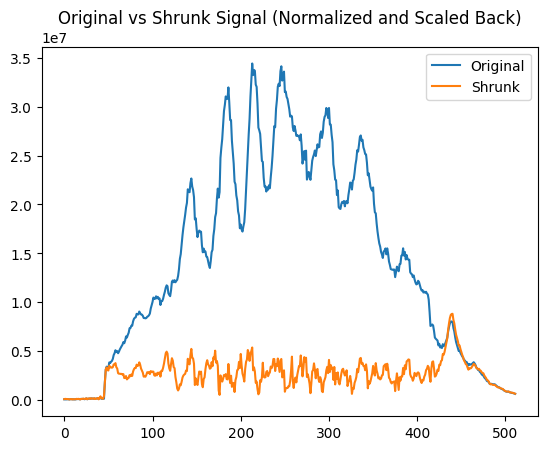

Test Segment Min/Max (Magnitude): 8624.591499060483 34446974.59536673
Normalized Test Segment Min/Max (Magnitude): 0.0002503729747058985 1.0
Shrunk Signal Min/Max (Magnitude): 5960.38302553444 8789859.660885392
YSig_normalized min/max (Magnitude): 0.00017303066802087572 0.2551707302059458


In [9]:
def mst_abs(Ssig, coarsest=3, finestlev=4):  # Further reduce finestlev to 4 to minimize boundary effects
    """
    Adaptive-Bayesian Shrinkage for one segment of complex IQ data.
    Ssig: Input complex segment (normalized to reasonable range)
    """
    # Separate real and imaginary parts
    real_part = Ssig.real
    imag_part = Ssig.imag
    
    # Forward Wavelet Transform for real and imaginary parts
    wavelet = 'db8'  # Keep Daubechies 8 for better signal representation
    coeffs_real = pywt.wavedec(real_part, wavelet, level=finestlev, mode='periodization')
    coeffs_imag = pywt.wavedec(imag_part, wavelet, level=finestlev, mode='periodization')
    
    # Flatten coefficients for real and imaginary parts
    datawd_real, coeff_slices = pywt.coeffs_to_array(coeffs_real)
    datawd_imag, _ = pywt.coeffs_to_array(coeffs_imag)  # Reuse coeff_slices
    
    # Print initial coefficient stats
    print("datawd_real min/max:", datawd_real.min(), datawd_real.max())
    print("datawd_imag min/max:", datawd_imag.min(), datawd_imag.max())
    
    # Compute prior parameters (combine real and imaginary for statistics)
    # Use magnitude for robustness
    datawd_mag = np.sqrt(datawd_real**2 + datawd_imag**2)
    niz = datawd_mag[2**finestlev:2**(finestlev+1)]
    nizo = np.sort(np.abs(niz))
    mm = len(nizo)
    Q1 = nizo[int(mm/4)] if mm > 0 else 0
    Q3 = nizo[int(3*mm/4)] if mm > 0 else 0
    Pseudos = max(abs(Q1 - Q3) / 1.5, 1e-2)  # Increase minimum Pseudos to 1e-2 for stability
    mu = min(1 / Pseudos**2 if Pseudos != 0 else 1e-1, 5.0)  # Reduce mu to 5.0 to prevent underflow
    
    # Scale of spread (τ) based on input signal magnitude
    sigma_d2 = np.var(np.abs(Ssig))
    tau = max(np.sqrt(max(sigma_d2 - (1/mu), 1e-6)), 0.5)  # Increase tau to 0.5 for stability
    
    print("mu:", mu)
    print("tau:", tau)
    print("Pseudos:", Pseudos)
    print("sigma_d2:", sigma_d2)
    
    # Iterative shrinkage across levels (for both real and imaginary)
    for i in range(finestlev, coarsest-1, -1):
        # Weight of point mass (ϵ)
        epsilon = min(1 - (1 / (i - coarsest + 1)**1.0), 0.3)  # Keep epsilon cap at 0.3 for more shrinkage
        
        # Real part
        d_real = datawd_real[2**i:2**(i+1)] if i < finestlev else datawd_real[2**i:]
        if len(d_real) == 0:
            continue
        
        # Imaginary part
        d_imag = datawd_imag[2**i:2**(i+1)] if i < finestlev else datawd_imag[2**i:]
        
        # Compute densities and shrinkage (using magnitude for stability)
        d_mag = np.maximum(np.sqrt(d_real**2 + d_imag**2), 1e-10)  # Ensure non-negative with small epsilon
        print(f"Level {i} - d_mag min/max:", d_mag.min(), d_mag.max())
        
        de = 0.5 * np.sqrt(2*mu) * np.exp(-np.sqrt(2*mu) * d_mag)
        print(f"Level {i} - de min/max:", de.min(), de.max())
        
        m = (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-np.sqrt(2*mu)*d_mag)) / (2*tau**2 - (1/mu))
        m = np.maximum(m, 1e-10)  # Ensure non-negative with small epsilon
        print(f"Level {i} - m min/max:", m.min(), m.max())
        
        m_star = epsilon * de + (1 - epsilon) * m
        print(f"Level {i} - m_star min/max:", m_star.min(), m_star.max())
        
        # Bayes rule shrinkage (apply to real and imaginary proportionally, with clipping)
        delta_mag = (tau * (tau**2 - 1/(2*mu)) * d_mag * np.exp(-d_mag/tau) + 
                     tau**2 * (np.exp(-d_mag*np.sqrt(2*mu)) - np.exp(-d_mag/tau))) / mu
        delta_mag = np.maximum(delta_mag, 0)  # Ensure non-negative
        print(f"Level {i} - delta_mag before division min/max:", delta_mag.min(), delta_mag.max())
        
        delta_mag /= ((tau**2 - 1/(2*mu)) * (tau * np.exp(-d_mag/tau) - (1/np.sqrt(2*mu)) * np.exp(-d_mag*np.sqrt(2*mu))) + 1e-10)  # Add small epsilon
        delta_mag = np.clip(delta_mag, 0, 0.3)  # Limit delta_mag to 0.3 to prevent over-shrinkage
        print(f"Level {i} - delta_mag min/max:", delta_mag.min(), delta_mag.max())
        
        delta_star = ((1 - epsilon) * m * delta_mag) / (m_star + 1e-10)  # Add small epsilon
        delta_star = np.clip(delta_star, 0, 0.3)  # Limit delta_star to 0.3 for controlled shrinkage
        print(f"Level {i} - delta_star min/max:", delta_star.min(), delta_star.max())
        
        # Update real and imaginary parts (scale by original magnitude direction)
        if len(d_real) > 0:
            direction = d_real + 1j * d_imag
            direction_mag = np.abs(direction)
            direction_normalized = direction / (direction_mag + 1e-10)  # Avoid division by zero
            delta_real = delta_star * direction_normalized.real
            delta_imag = delta_star * direction_normalized.imag
            
            if i < finestlev:
                datawd_real[2**i:2**(i+1)] = delta_real
                datawd_imag[2**i:2**(i+1)] = delta_imag
            else:
                datawd_real[2**i:] = delta_real
                datawd_imag[2**i:] = delta_imag
    
    # Inverse Wavelet Transform for real and imaginary parts
    coeffs_updated_real = pywt.array_to_coeffs(datawd_real, coeff_slices, output_format='wavedec')
    coeffs_updated_imag = pywt.array_to_coeffs(datawd_imag, coeff_slices, output_format='wavedec')
    YSig_real = pywt.waverec(coeffs_updated_real, wavelet, mode='periodization')
    YSig_imag = pywt.waverec(coeffs_updated_imag, wavelet, mode='periodization')
    
    # Combine real and imaginary parts
    YSig = YSig_real + 1j * YSig_imag
    
    return YSig[:len(Ssig)]  # Ensure output matches input length

# Test on one segment with normalization
test_segment = segmented_data[0, 0, :]
max_magnitude = np.abs(test_segment).max()
test_segment_normalized = test_segment / (max_magnitude + 1e-10)  # Normalize to max magnitude of 1

YSig_normalized = mst_abs(test_segment_normalized)
YSig_scaled = YSig_normalized * max_magnitude  # Scale back to original magnitude range

plt.plot(np.abs(test_segment), label='Original')
plt.plot(np.abs(YSig_scaled), label='Shrunk')
plt.legend()
plt.title('Original vs Shrunk Signal (Normalized and Scaled Back)')
plt.show()

# Debug prints for input and output
print("Test Segment Min/Max (Magnitude):", np.abs(test_segment).min(), np.abs(test_segment).max())
print("Normalized Test Segment Min/Max (Magnitude):", np.abs(test_segment_normalized).min(), np.abs(test_segment_normalized).max())
print("Shrunk Signal Min/Max (Magnitude):", np.abs(YSig_scaled).min(), np.abs(YSig_scaled).max())
print("YSig_normalized min/max (Magnitude):", np.abs(YSig_normalized).min(), np.abs(YSig_normalized).max())

In [10]:
# Data Preparation
def prepare_cae_data(iq_data, num_samples=1000, noise_factor=0.1):
    """
    Prepare noisy-clean pairs for CAE training.
    iq_data: 5D array (CYCLES, BEAMS, INCI, RANGE_BINS, NFFT)
    """
    samples = iq_data.reshape(-1, iq_data.shape[-1])[:num_samples]
    max_magnitude = np.max(np.abs(samples))
    samples_normalized = samples / max_magnitude
    noise = noise_factor * np.random.normal(0, 1, samples.shape)
    noisy_samples = samples + noise
    X_noisy = np.stack([noisy_samples.real, noisy_samples.imag], axis=-1)
    X_clean = np.stack([samples_normalized.real, samples_normalized.imag], axis=-1)
    return X_noisy, X_clean, max_magnitude

# Building CAE Model with PyTorch
class CAE(nn.Module):
    def __init__(self, input_shape=(256, 2)):
        super(CAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv1d(in_channels=32, out_channels=2, kernel_size=3, padding=1)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training CAE
def train_cae(X_noisy, X_clean, epochs=20, batch_size=32, device='cpu'):
    """
    Train the CAE model.
    X_noisy: Noisy input data (samples, NFFT, 2)
    X_clean: Clean target data (samples, NFFT, 2)
    """
    # Convert to PyTorch tensors
    X_noisy_tensor = torch.tensor(X_noisy, dtype=torch.float32).permute(0, 2, 1)  # (samples, 2, NFFT)
    X_clean_tensor = torch.tensor(X_clean, dtype=torch.float32).permute(0, 2, 1)  # (samples, 2, NFFT)
    
    # Create dataset and dataloader
    dataset = TensorDataset(X_noisy_tensor, X_clean_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model, loss, and optimizer
    model = CAE().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for noisy, clean in dataloader:
            noisy, clean = noisy.to(device), clean.to(device)
            optimizer.zero_grad()
            outputs = model(noisy)
            loss = criterion(outputs, clean)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.6f}")
    
    return model

# Denoising with CAE
def denoise_with_cae(iq_segment, model, max_magnitude, device='cpu'):
    """
    Denoise a single IQ segment using the trained CAE.
    iq_segment: 1D complex array (NFFT,)
    model: Trained CAE model
    max_magnitude: Scaling factor for normalization
    """
    model.eval()
    # Normalize and reshape
    iq_normalized = iq_segment / max_magnitude
    iq_reshaped = np.stack([iq_normalized.real, iq_normalized.imag], axis=-1)[np.newaxis, :]
    iq_tensor = torch.tensor(iq_reshaped, dtype=torch.float32).permute(0, 2, 1).to(device)  # (1, 2, NFFT)
    
    # Predict
    with torch.no_grad():
        denoised = model(iq_tensor)
    
    # Reconstruct complex signal
    denoised = denoised.permute(0, 2, 1).cpu().numpy()[0]  # (NFFT, 2)
    denoised_complex = denoised[:, 0] + 1j * denoised[:, 1]
    return denoised_complex * max_magnitude

# Test
if __name__ == "__main__":
    # Simulated IQ data
    CYCLES, BEAMS, INCI, RANGE_BINS, NFFT = 10, 5, 2, 100, 256
    iq_data = np.random.randn(CYCLES, BEAMS, INCI, RANGE_BINS, NFFT) + \
              1j * np.random.randn(CYCLES, BEAMS, INCI, RANGE_BINS, NFFT)
    
    # Prepare data
    X_noisy, X_clean, max_magnitude = prepare_cae_data(iq_data)
    
    # Train CAE
    device = torch.device('cpu')  # Use 'cuda' if GPU is available
    cae_model = train_cae(X_noisy, X_clean, device=device)
    
    # Denoise a test segment
    test_segment = iq_data[0, 0, 0, 0, :]
    ysig_ml = denoise_with_cae(test_segment, cae_model, max_magnitude, device=device)
    print("Denoised signal shape:", ysig_ml.shape)

Epoch 1/20, Loss: 0.037604
Epoch 2/20, Loss: 0.031253
Epoch 3/20, Loss: 0.028217
Epoch 4/20, Loss: 0.026788
Epoch 5/20, Loss: 0.025457
Epoch 6/20, Loss: 0.023917
Epoch 7/20, Loss: 0.022156
Epoch 8/20, Loss: 0.020325
Epoch 9/20, Loss: 0.019031
Epoch 10/20, Loss: 0.017929
Epoch 11/20, Loss: 0.016563
Epoch 12/20, Loss: 0.015240
Epoch 13/20, Loss: 0.014107
Epoch 14/20, Loss: 0.013172
Epoch 15/20, Loss: 0.012289
Epoch 16/20, Loss: 0.011658
Epoch 17/20, Loss: 0.011089
Epoch 18/20, Loss: 0.010656
Epoch 19/20, Loss: 0.010169
Epoch 20/20, Loss: 0.009782
Denoised signal shape: (256,)


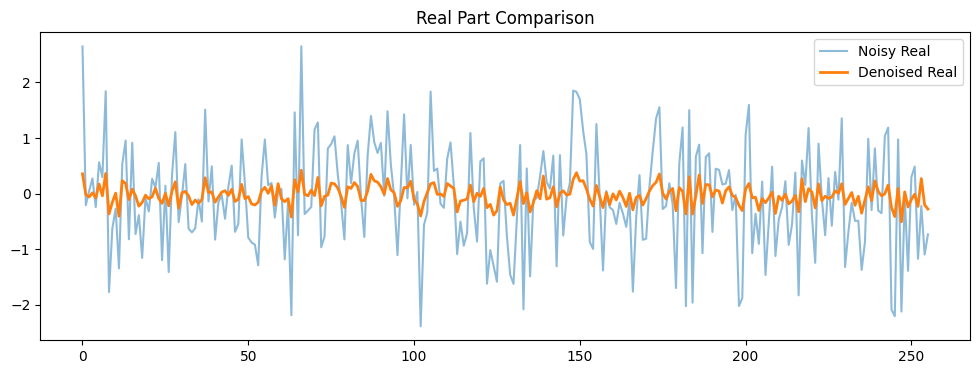

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(test_segment.real, label='Noisy Real', alpha=0.5)
plt.plot(ysig_ml.real, label='Denoised Real', linewidth=2)
plt.legend()
plt.title('Real Part Comparison')
plt.show()

Epoch 1/20, Loss: 0.019865
Epoch 2/20, Loss: 0.016625
Epoch 3/20, Loss: 0.014130
Epoch 4/20, Loss: 0.012339
Epoch 5/20, Loss: 0.011050
Epoch 6/20, Loss: 0.010058
Epoch 7/20, Loss: 0.009240
Epoch 8/20, Loss: 0.008517
Epoch 9/20, Loss: 0.007880
Epoch 10/20, Loss: 0.007311
Epoch 11/20, Loss: 0.006796
Epoch 12/20, Loss: 0.006336
Epoch 13/20, Loss: 0.005932
Epoch 14/20, Loss: 0.005589
Epoch 15/20, Loss: 0.005287
Epoch 16/20, Loss: 0.005030
Epoch 17/20, Loss: 0.004817
Epoch 18/20, Loss: 0.004634
Epoch 19/20, Loss: 0.004468
Epoch 20/20, Loss: 0.004315


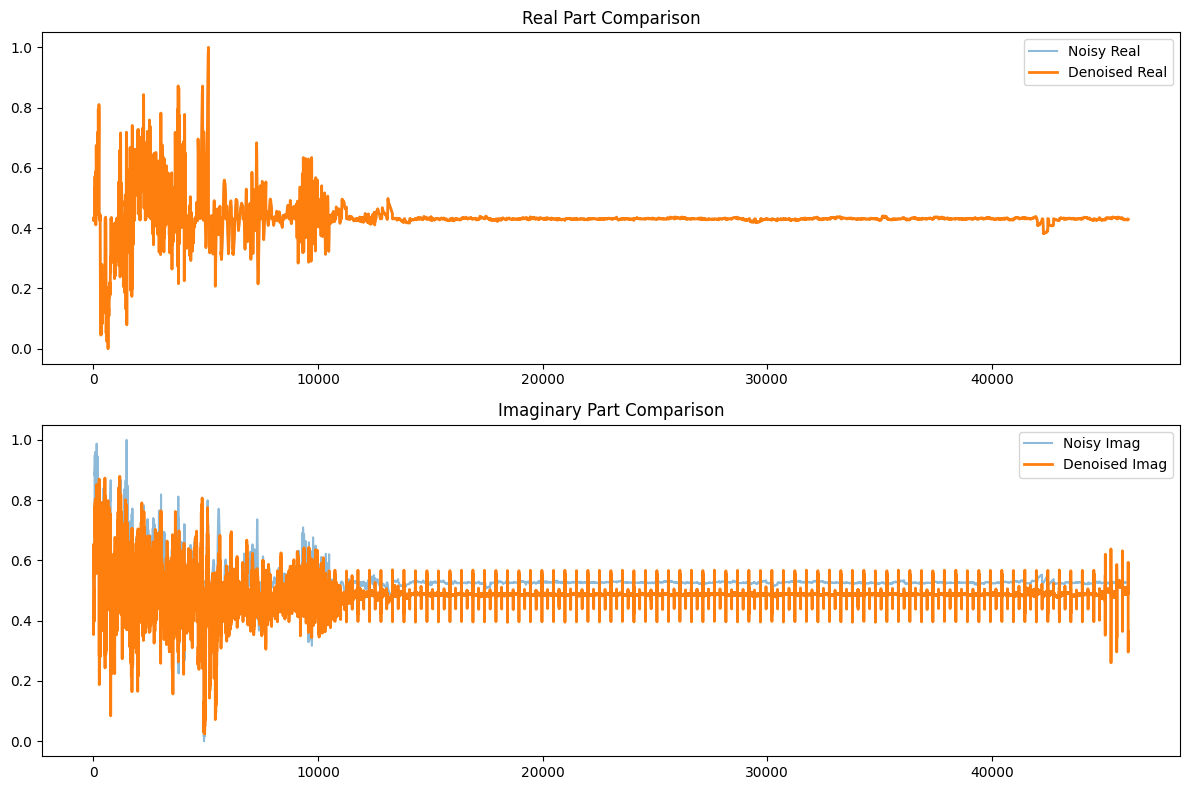

In [17]:
# Lightweight CAE for CPU
class RadarCAE(nn.Module):
    def __init__(self):
        super(RadarCAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1),  # 2 channels: Real (I) and Imag (Q)
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),  # Downsample
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # Upsample
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 2, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Output normalized to [0, 1]
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

# Data Preprocessing
def load_and_preprocess_data(file_path, variable_i='RawI.R.1.C.1.B.1', variable_q='RawQ.R.1.C.1.B.1', beam_idx=0):
    dataset = nc.Dataset(file_path, 'r')
    raw_i = dataset.variables[variable_i][:]  # Shape: (beams, time, range) or similar
    raw_q = dataset.variables[variable_q][:]  # Shape: (beams, time, range) or similar
    dataset.close()

    # Select a single beam to reduce to 2D
    if raw_i.ndim == 3:
        raw_i = raw_i[beam_idx]  # Shape: (time, range)
        raw_q = raw_q[beam_idx]  # Shape: (time, range)

    # Apply wavelet denoising (optional)
    def wavelet_denoise(signal, wavelet='db4', level=4, threshold_type='soft'):
        coeffs = pywt.wavedec(signal, wavelet, level=level, axis=-1)
        threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(signal.size))
        coeffs[1:] = [pywt.threshold(c, threshold, mode=threshold_type) for c in coeffs[1:]]
        return pywt.waverec(coeffs, wavelet, axis=-1)

    raw_i = wavelet_denoise(raw_i, wavelet='db4', level=4)
    raw_q = wavelet_denoise(raw_q, wavelet='db4', level=4)

    # Combine into complex signal and take real/imag parts
    signal = raw_i + 1j * raw_q
    real_part = np.real(signal)
    imag_part = np.imag(signal)

    # Normalize to [0, 1]
    real_part = (real_part - real_part.min()) / (real_part.max() - real_part.min() + 1e-8)
    imag_part = (imag_part - imag_part.min()) / (imag_part.max() - imag_part.min() + 1e-8)

    # Reshape for CAE: (batch_size, channels, height, width)
    data = np.stack([real_part, imag_part], axis=0)  # Shape: (2, time, range)
    data = data[np.newaxis, :]  # Shape: (1, 2, time, range)
    return torch.tensor(data, dtype=torch.float32)

# Prepare DataLoader
def create_dataloader(data, batch_size=1):
    dataset = TensorDataset(data, data)  # Un unsupervised: input = target
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training Loop
def train_cae(model, dataloader, epochs=20, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            inputs = batch[0]  # No .cuda() for CPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.6f}")

# Main Execution
if __name__ == "__main__":
    # Load and preprocess data
    file_path = "29AP2022SHT1_r5_BAPBS_p.nc"
    data = load_and_preprocess_data(file_path, beam_idx=0)  # Process first beam
    
    # Create DataLoader
    dataloader = create_dataloader(data, batch_size=1)
    
    # Initialize and train model
    model = RadarCAE()
    train_cae(model, dataloader, epochs=20)
    
    # Inference example
    with torch.no_grad():
        denoised = model(data).numpy()
    
    # Visualization
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(data[0, 0].numpy().flatten(), label='Noisy Real', alpha=0.5)
    plt.plot(data[0, 0].numpy().flatten(), label='Denoised Real', linewidth=2)
    plt.legend()
    plt.title('Real Part Comparison')
    plt.subplot(2, 1, 2)
    plt.plot(data[0, 1].numpy().flatten(), label='Noisy Imag', alpha=0.5)
    plt.plot(denoised[0, 1].flatten(), label='Denoised Imag', linewidth=2)
    plt.legend()
    plt.title('Imaginary Part Comparison')
    plt.tight_layout()
    plt.show()

In [20]:
dataset = nc.Dataset(file_path, 'r')
print(f"RawI shape: {dataset.variables['RawI.R.1.C.1.B.1'].shape}")
print(f"RawQ shape: {dataset.variables['RawQ.R.1.C.1.B.1'].shape}")
dataset.close()

RawI shape: (5, 180, 256)
RawQ shape: (5, 180, 256)


In [21]:
def compute_snr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    signal_power = np.mean(original ** 2)
    return 10 * np.log10(signal_power / mse)

snr_real = compute_snr(data[0, 0].numpy(), denoised[0, 0])
print(f"SNR (Real): {snr_real:.2f} dB")

SNR (Real): 15.80 dB


In [22]:
import numpy as np

def compute_snr(noisy, denoised):
    residual = noisy - denoised  # Estimate noise as difference
    signal_power = np.mean(denoised ** 2)
    noise_power = np.mean(residual ** 2)
    snr = 10 * np.log10(signal_power / (noise_power + 1e-8))  # Avoid division by zero
    return snr

# Example usage after training
with torch.no_grad():
    denoised = model(data).numpy()  # From previous code
snr_real = compute_snr(data[0, 0].numpy(), denoised[0, 0])
snr_imag = compute_snr(data[0, 1].numpy(), denoised[0, 1])
print(f"SNR (Real): {snr_real:.2f} dB")
print(f"SNR (Imag): {snr_imag:.2f} dB")

SNR (Real): 16.93 dB
SNR (Imag): 18.66 dB


In [23]:
import torch

criterion = torch.nn.MSELoss()
with torch.no_grad():
    mse = criterion(model(data), data).item()
print(f"Reconstruction MSE: {mse:.6f}")

Reconstruction MSE: 0.004169


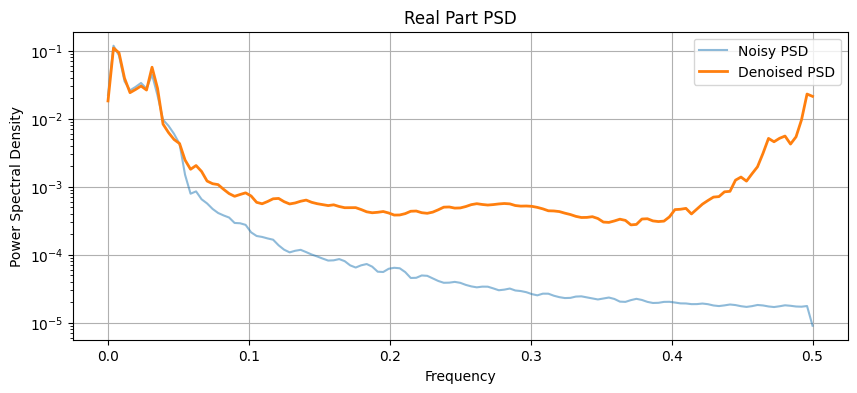

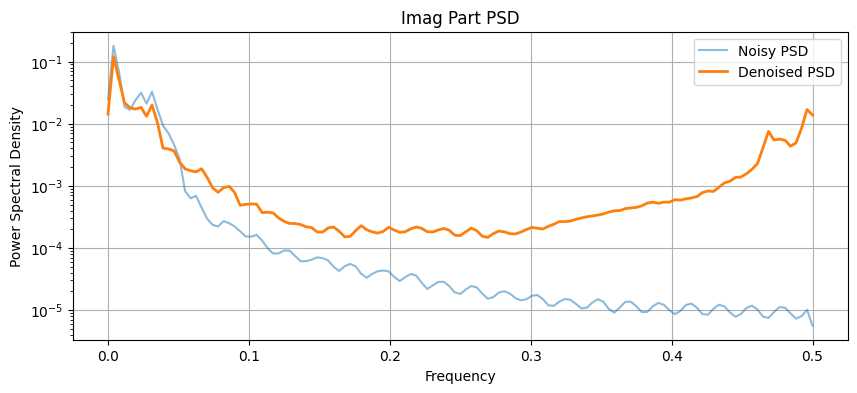

In [24]:
from scipy.signal import welch
import matplotlib.pyplot as plt

def compare_psd(noisy, denoised, fs=1.0, title="PSD Comparison"):
    freqs_noisy, psd_noisy = welch(noisy.flatten(), fs=fs)
    freqs_denoised, psd_denoised = welch(denoised.flatten(), fs=fs)
    plt.figure(figsize=(10, 4))
    plt.semilogy(freqs_noisy, psd_noisy, label="Noisy PSD", alpha=0.5)
    plt.semilogy(freqs_denoised, psd_denoised, label="Denoised PSD", linewidth=2)
    plt.xlabel("Frequency")
    plt.ylabel("Power Spectral Density")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

compare_psd(data[0, 0].numpy(), denoised[0, 0], title="Real Part PSD")
compare_psd(data[0, 1].numpy(), denoised[0, 1], title="Imag Part PSD")

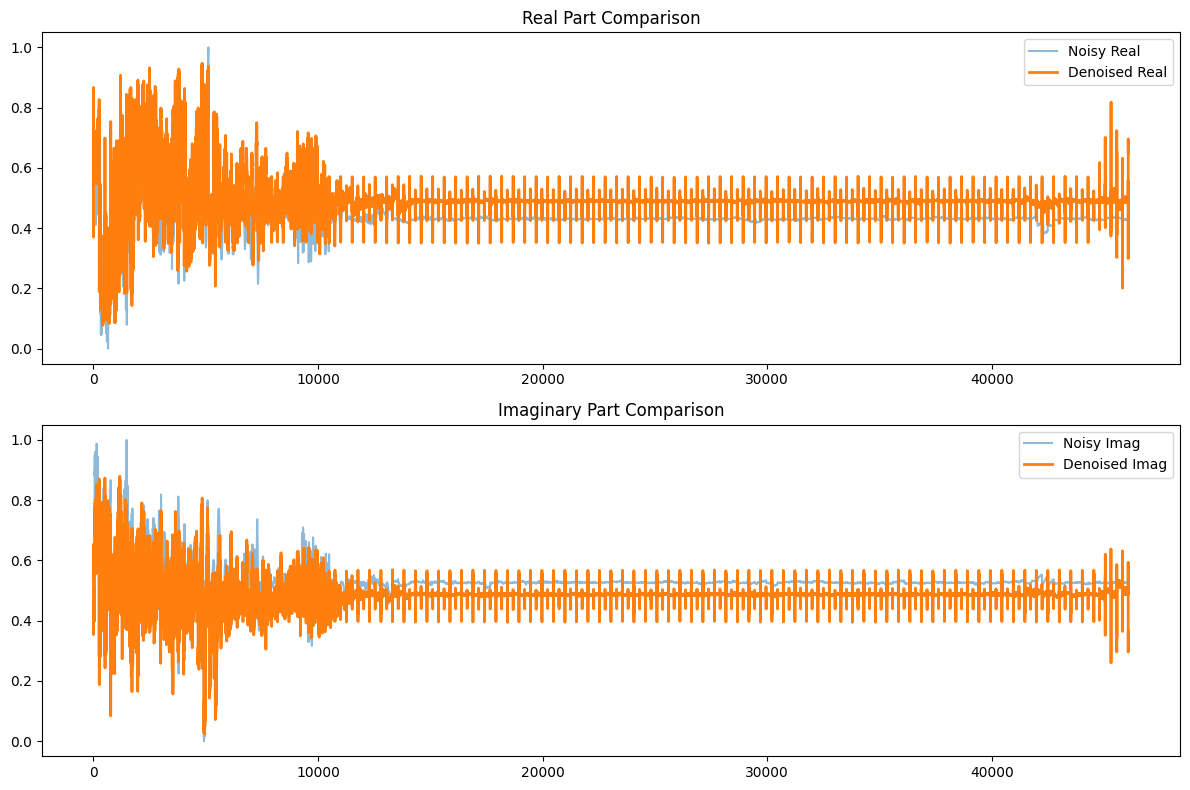

In [25]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(data[0, 0].numpy().flatten(), label='Noisy Real', alpha=0.5)
plt.plot(denoised[0, 0].flatten(), label='Denoised Real', linewidth=2)
plt.legend()
plt.title('Real Part Comparison')
plt.subplot(2, 1, 2)
plt.plot(data[0, 1].numpy().flatten(), label='Noisy Imag', alpha=0.5)
plt.plot(denoised[0, 1].flatten(), label='Denoised Imag', linewidth=2)
plt.legend()
plt.title('Imaginary Part Comparison')
plt.tight_layout()
plt.show()

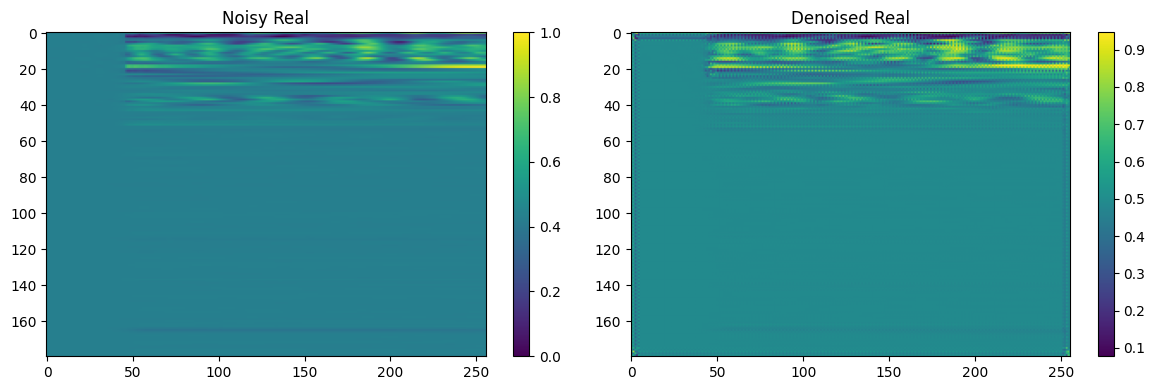

In [26]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(data[0, 0].numpy(), aspect='auto', cmap='viridis')
plt.title('Noisy Real')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(denoised[0, 0], aspect='auto', cmap='viridis')
plt.title('Denoised Real')
plt.colorbar()
plt.tight_layout()
plt.show()

In [27]:
def load_trace_peak(file_path, variable='TracePeak.R.1.C.1.B.1'):
    dataset = nc.Dataset(file_path, 'r')
    trace_peak = dataset.variables[variable][:]
    dataset.close()
    return trace_peak

trace_peak = load_trace_peak(file_path)
# Compare peaks in noisy vs. denoised (simplified example)
from scipy.signal import find_peaks
noisy_peaks, _ = find_peaks(data[0, 0].numpy().flatten(), height=0.5)
denoised_peaks, _ = find_peaks(denoised[0, 0].flatten(), height=0.5)
print(f"Noisy peaks detected: {len(noisy_peaks)}")
print(f"Denoised peaks detected: {len(denoised_peaks)}")

Noisy peaks detected: 144
Denoised peaks detected: 3876


In [28]:
def compute_moment(signal):
    return np.mean(signal), np.std(signal)  # Mean and width
noisy_mean, noisy_std = compute_moment(data[0, 0].numpy().flatten())
denoised_mean, denoised_std = compute_moment(denoised[0, 0].flatten())
print(f"Noisy: Mean={noisy_mean:.4f}, Std={noisy_std:.4f}")
print(f"Denoised: Mean={denoised_mean:.4f}, Std={denoised_std:.4f}")

Noisy: Mean=0.4350, Std=0.0573
Denoised: Mean=0.4952, Std=0.0659


In [ ]:
channels = [f'C.{i}' for i in range(1, 18)]
train_channels = channels[:10]
val_channels = channels[10:]
train_data = []
val_data = []

for c in train_channels:
    data = load_and_preprocess_data(file_path, f'RawI.R.1.{c}.B.1', f'RawQ.R.1.{c}.B.1', beam_idx=0)
    train_data.append(data)
for c in val_channels:
    data = load_and_preprocess_data(file_path, f'RawI.R.1.{c}.B.1', f'RawQ.R.1.{c}.B.1', beam_idx=0)
    val_data.append(data)

train_data = torch.cat(train_data, dim=0)
val_data = torch.cat(val_data, dim=0)
train_loader = create_dataloader(train_data, batch_size=1)
val_loader = create_dataloader(val_data, batch_size=1)

# Modified training loop with validation
def train_cae_with_val(model, train_loader, val_loader, epochs=20, lr=0.001):
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            inputs = batch[0]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch[0]
                outputs = model(inputs)
                val_loss += criterion(outputs, inputs).item()
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.6f}, Val Loss: {val_loss/len(val_loader):.6f}")

model = RadarCAE()
train_cae_with_val(model, train_loader, val_loader, epochs=20)

TypeError: load_and_preprocess_data() got an unexpected keyword argument 'beam_idx'

In [31]:
def wavelet_denoise(signal, wavelet='db4', level=4, threshold_type='soft'):
    coeffs = pywt.wavedec(signal, wavelet, level=level, axis=-1)
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(signal.size))
    coeffs[1:] = [pywt.threshold(c, threshold, mode=threshold_type) for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet, axis=-1)

wavelet_denoised = wavelet_denoise(data[0, 0].numpy())
snr_wavelet = compute_snr(data[0, 0].numpy(), wavelet_denoised)
print(f"Wavelet SNR (Real): {snr_wavelet:.2f} dB")

Wavelet SNR (Real): 53.86 dB


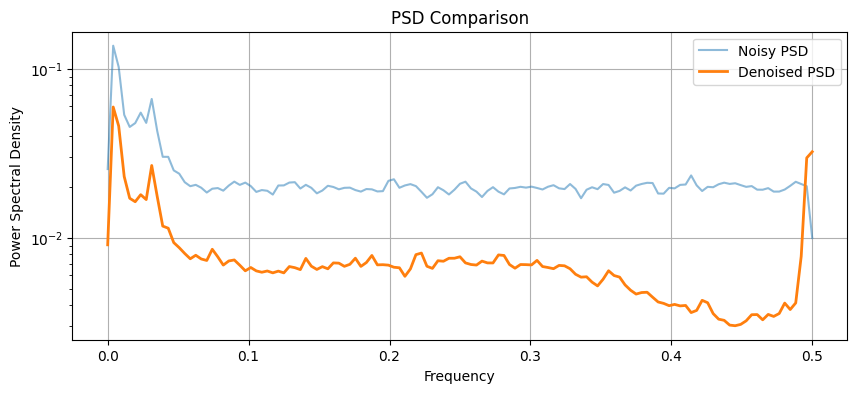

In [32]:
noisy_data = data + torch.randn_like(data) * 0.1  # Add noise
with torch.no_grad():
    denoised_noisy = model(noisy_data).numpy()
compare_psd(noisy_data[0, 0].numpy(), denoised_noisy[0, 0])